# Dask in ztfimg

The [`dask`](https://docs.dask.org/en/stable/) library enables to distribute computing between cluster (or to multiprocess from your machine). This library is natively incorporated within `ztfimg` to enable you to work with thousands fast and without exploding your memory.

The most natural way to use dask is by setting the `use_dask` option to True while loading a datafile. `data` will be stored as a `dask.array` in place of a `numpy.array`.

***
## Dask Cluster

let's create a dask cluster. For this example, we will create one from the local machine, but the core interest of dask is that all computing will automatically scale whatever cluster you have access to ; see [dask jobqueue](https://jobqueue.dask.org/en/latest/)

In [1]:
import dask
from dask.distributed import Client
client = Client()

with that, you are all set ! Open you localhost:8787

***
## *Dask*ing a science image

Following the **quickstart** tutorial:

In [3]:
import ztfimg
img = ztfimg.ScienceQuadrant.from_filename("ztf_20200924431759_000655_zr_c13_o_q3_sciimg.fits",
                                          as_path=False, use_dask=True)

With dask, no actual computation is made while loading the data

The `data` attribute is a `dask.array`.

In [4]:
img.data

dask.array<from-value, shape=(3080, 3072), dtype=float32, chunksize=(3080, 3072), chunktype=numpy.ndarray>

and if you set `as_path=False` the ztfquery.get_file() function itself is delayed, so img.filename is a delayed object

In [5]:
img.filename

Delayed('get_file-120676b3-3acd-47fb-9240-8ca243c1d922')

remark that the meta data are still known because they are based on the input filename.

***
## Data access

All computations are delaued, so whatever comes out of get_data() will also be a dask.array

In [6]:
data_clean = img.get_data(apply_mask=True)
data_clean

dask.array<where, shape=(3080, 3072), dtype=float32, chunksize=(3080, 3072), chunktype=numpy.ndarray>

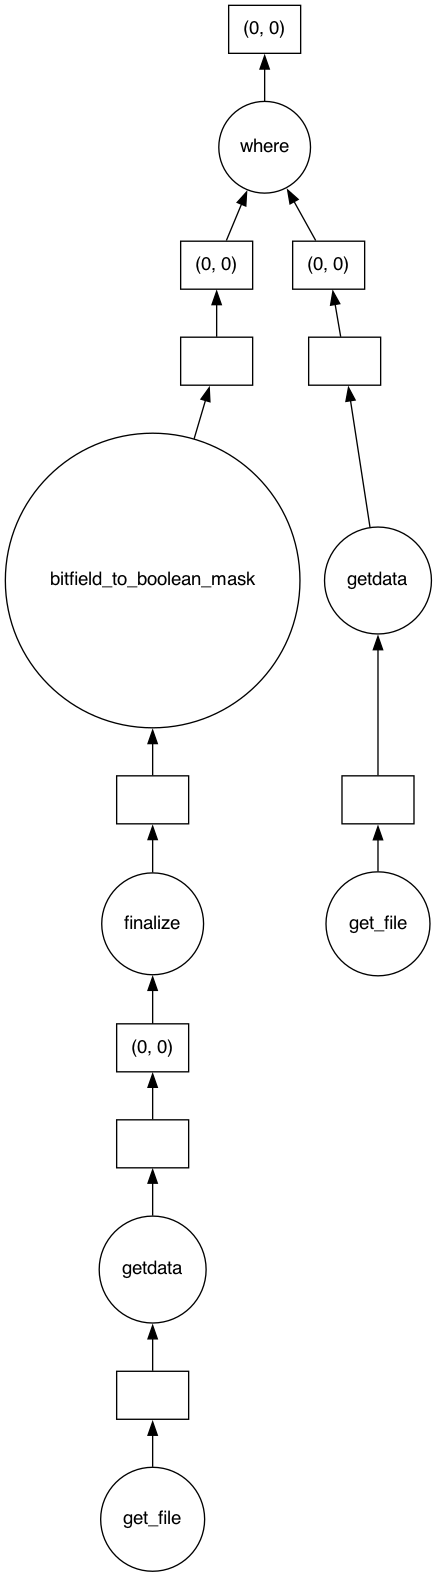

In [7]:
data_clean.visualize()

to get the actual array, simply do: .compute()

In [8]:
data = data_clean.compute() # check you dask dashboard at localhost:8787

In [9]:
data

array([[156.70863 , 157.65231 , 160.41643 , ..., 133.77336 ,  83.76391 ,
         12.984478],
       [155.4496  , 147.19606 , 161.0656  , ..., 134.86244 ,  83.728935,
         10.205329],
       [154.41986 , 159.50085 , 165.22946 , ..., 139.25365 ,  76.01857 ,
         16.900919],
       ...,
       [167.03732 , 154.78484 , 148.68439 , ..., 152.8368  ,  87.123825,
         17.609827],
       [158.07927 , 149.92209 , 152.68452 , ..., 138.10672 ,  78.78005 ,
         16.670918],
       [194.94452 , 196.35838 , 185.91528 , ..., 206.81393 , 167.88715 ,
         44.91321 ]], dtype=float32)

***
## Stack bias images

`dask` computing is particularly useful when dealing with many images. Let's use here an example where we want to stack the 10 bias images of a given day.

In [11]:
filename_biases = [
 'ztf_20200801078252_000000_bi_c13_b.fits.fz',
 'ztf_20200801078484_000000_bi_c13_b.fits.fz',
 'ztf_20200801078727_000000_bi_c13_b.fits.fz',
 'ztf_20200801078958_000000_bi_c13_b.fits.fz',
 'ztf_20200801079201_000000_bi_c13_b.fits.fz',
 'ztf_20200801079444_000000_bi_c13_b.fits.fz',
 'ztf_20200801079676_000000_bi_c13_b.fits.fz',
 'ztf_20200801079919_000000_bi_c13_b.fits.fz',
 'ztf_20200801080162_000000_bi_c13_b.fits.fz',
 'ztf_20200801080394_000000_bi_c13_b.fits.fz']
len(filename_biases)

10

### Opening one image without dask

In [12]:
bias = ztfimg.RawCCD.from_filename(filename_biases[0], as_path=False)

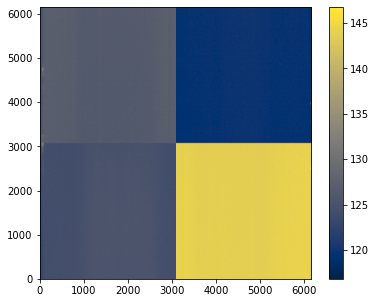

In [13]:
_ = bias.show()

In [14]:
data = bias.get_data(corr_nl=True, corr_overscan=True)
data

array([[-0.46397033, -3.1460078 ,  1.054943  , ..., -0.44659588,
         0.3569472 ,  1.391783  ],
       [-1.9575412 , -1.3435428 ,  0.5253918 , ...,  0.9899193 ,
         1.0691429 , -3.938929  ],
       [-0.5182889 ,  0.42228577,  0.274039  , ..., -3.6081266 ,
        -0.28328228, -1.2028227 ],
       ...,
       [-1.8358457 , -2.7859266 , -2.20343   , ...,  0.13364159,
        -2.2113597 , -1.97111   ],
       [-1.2231889 , -3.1944566 ,  1.1322417 , ..., -0.31865025,
        -3.4429789 , -2.6049128 ],
       [-1.0165837 , -1.1530507 ,  1.4502361 , ..., -2.3285668 ,
         0.12724365, -0.58615816]], dtype=float32)

### Opening with dask and stacking them

In [15]:
%%time
biases = [ztfimg.RawCCD.from_filename(filename_, as_path=False, use_dask=True)
         for filename_ in filename_biases]

CPU times: user 9.6 ms, sys: 947 µs, total: 10.5 ms
Wall time: 11.4 ms


all data loading (downloading) are delayed

In [16]:
biases

In [17]:
biases[0].get_data(corr_nl=True, corr_overscan=True)

dask.array<concatenate, shape=(6160, 6144), dtype=float32, chunksize=(3080, 3072), chunktype=numpy.ndarray>

So to stack them, simply get all the dask arrays and sum/average them

In [18]:
import dask.array as da

In [19]:
%%time 
stacked = da.stack([bias_.get_data(corr_nl=True, corr_overscan=True) for bias_ in biases])
# no computing yet

CPU times: user 23.6 ms, sys: 2.88 ms, total: 26.5 ms
Wall time: 27.2 ms


In [20]:
averaged_data = da.mean(stacked, axis=0)
averaged_data

dask.array<mean_agg-aggregate, shape=(6160, 6144), dtype=float32, chunksize=(3080, 3072), chunktype=numpy.ndarray>

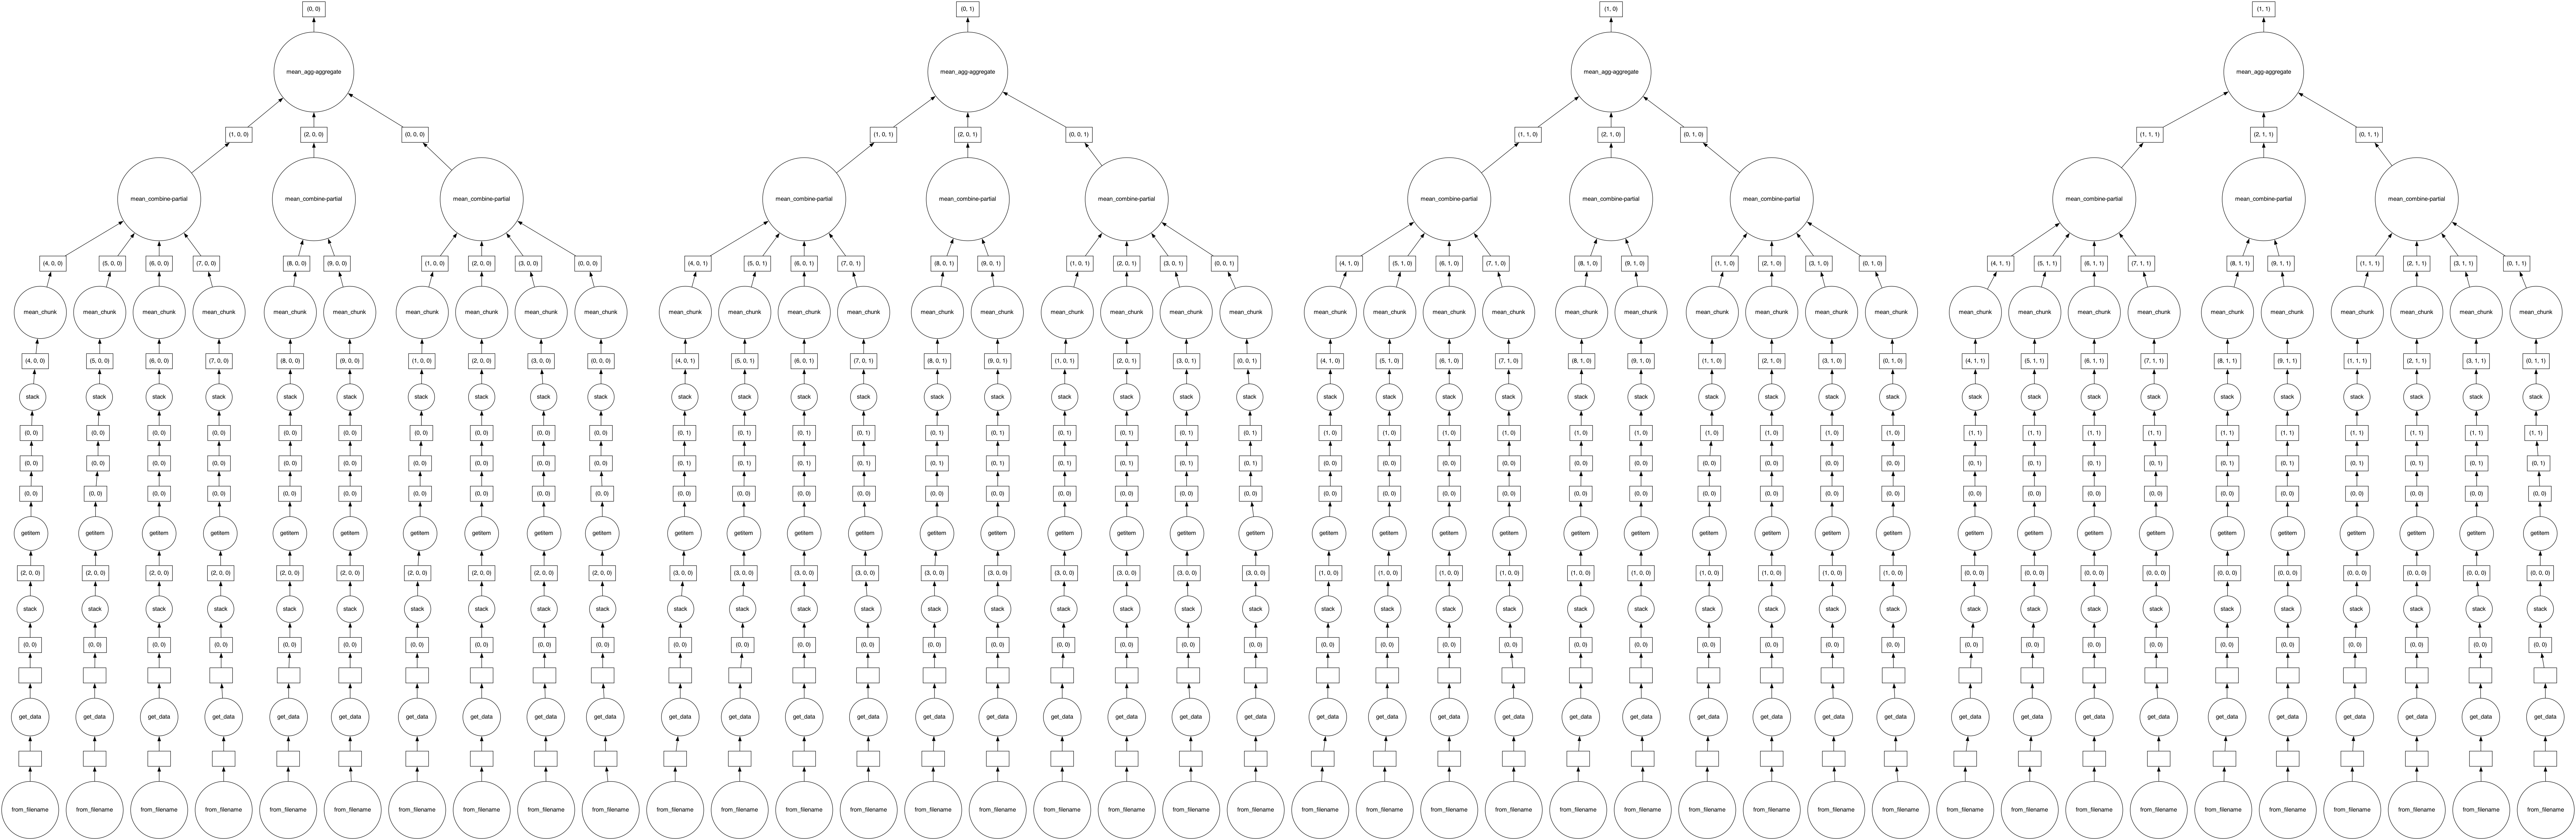

In [21]:
averaged_data.visualize() # these are all the tasks to do

on now let's run the computation. Dask will exploite the parallelism on the process (check the dask dashboard on localhost:8787)

In [25]:
%%time
data = averaged_data.compute() 

CPU times: user 732 ms, sys: 237 ms, total: 969 ms
Wall time: 3.55 s


In [26]:
data

array([[-1.1963512 , -1.7856996 , -0.3789768 , ..., -0.85070735,
        -1.0194528 , -0.53417444],
       [-1.5594597 , -0.18655245, -0.2395775 , ..., -0.8350952 ,
        -0.35432133, -1.2835388 ],
       [-0.27430466, -1.0491558 , -0.5911679 , ..., -1.2418035 ,
        -1.1251014 , -1.1696676 ],
       ...,
       [-0.15636775, -0.6973864 , -1.6802683 , ...,  0.01649523,
        -0.94407684, -0.56049454],
       [-1.3368918 , -1.2315245 , -1.3852476 , ..., -1.3641628 ,
        -2.3233888 , -1.8894246 ],
       [-1.1199983 , -1.1898156 , -0.9116205 , ..., -0.65492904,
        -0.3362218 , -1.3545789 ]], dtype=float32)

**careful** if you are running this on your own machine (and not a cluster) the RAM will be limited to you single computer RAM, so do not open in // too many files. 